# Classifying Chest X-Ray Images (Pneumonia)
### Markowitz Working NB - Fully Connected NN

Dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [94]:
import os, shutil
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from markowitz_functions import get_images, preprocess_dense_data, visualize_training_results,\
                                get_class_weights, show_misclassfied_images

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading images from local folders

The original `val` folder from Kaggle contained only 8 images *each* from Normal and Pneumonia, which is not a sufficient size for validation. 

Rather than adding files to that folder to increase the size of the validation set, we have chosen to move **all** images into the `train` folder. We will then use the `val_split` parameter in `flow_from_directory` to instantiate a validation set.

In [62]:
# Filepaths
train_dir = 'chest_xray/train'
# validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/' 

In [63]:
# Check functionality and num images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir

'chest_xray/train/NORMAL'

In [64]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [65]:
print('There are', len(os.listdir(train_normal_dir)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia_dir)), 'pneumonia images in the training set')

There are 1349 normal images in the training set
There are 3883 pneumonia images in the training set


### EDA: Image Samples and Metadata

In [66]:
# Get list of filenames of all training images
train_norm_filenames = os.listdir(train_normal_dir)
train_pneum_filenames = os.listdir(train_pneumonia_dir)

In [67]:
# Make list of full filepaths to each image
train_normal_filepaths = [os.path.join(train_normal_dir, name) for name in train_norm_filenames]
train_pneumonia_filepaths = [os.path.join(train_pneumonia_dir, name) for name in train_pneum_filenames]

In [68]:
train_normal_filepaths[:10]

['chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0561-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0757-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-0736-0001.jpeg']

In [69]:
# Get training images of normal and pneumonia
# Read each file in as an image
train_normal_images = get_images(train_normal_dir)
train_pneumonia_images = get_images(train_pneumonia_dir)

#### Show the first 5 images from each set:

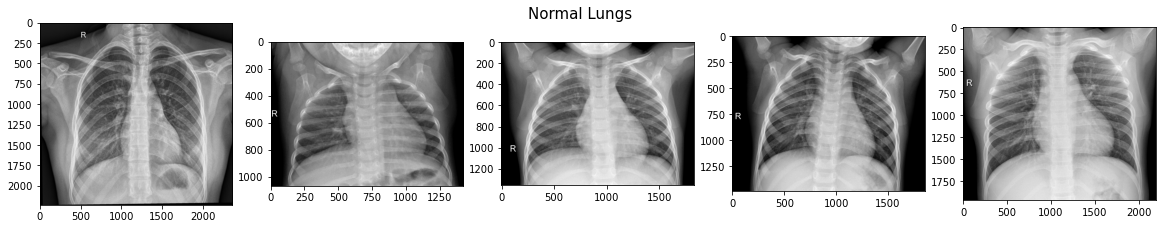

In [70]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_normal_images[i], cmap='gray')
fig.suptitle('Normal Lungs', fontsize=15, y=.8)
fig.tight_layout;

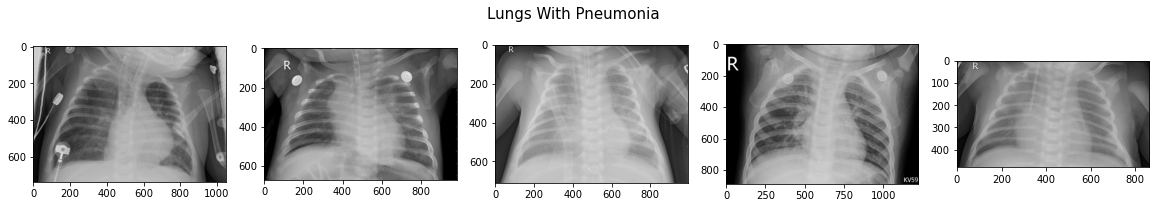

In [71]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_pneumonia_images[i], cmap='gray')
fig.suptitle('Lungs With Pneumonia', fontsize=15, y=.8)
fig.tight_layout;

**Notes:**
 - All photos are single-channel (black and white, not RGB)
 - All x-ray photos have 'R' to designate right-side lung
 - Pneumonia lungs have EKG(?) electrodes(?)--possible confounding factor for NN?
 - Pneumonia lungs look "cloudy" or "fuzzy" compared to Normal

From Kaggle:
> The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Essentially, this means that bacterial pneumonia typically gathers in one area of the lungs, while viral penumonia is more spread out.

#### Metadata

In [72]:
# Dimensions of images
normal_img_shapes = [img.shape for img in train_normal_images]
pneumonia_img_shapes = [img.shape for img in train_pneumonia_images]

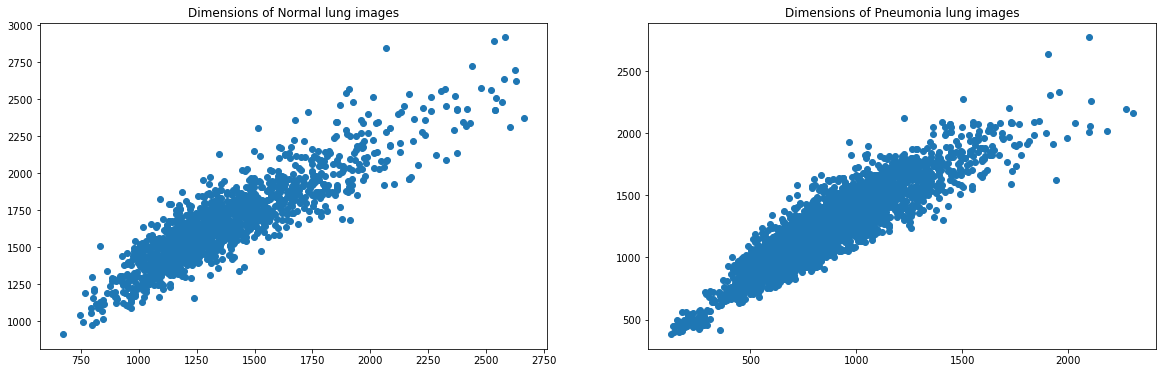

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Sizes of Normal lung images
ax1.scatter(x=[x[0] for x in normal_img_shapes], y=[x[1] for x in normal_img_shapes])
ax1.set_title('Dimensions of Normal lung images')

# Sizes of Pneumonia lung images
ax2.scatter(x=[x[0] for x in pneumonia_img_shapes], y=[x[1] for x in pneumonia_img_shapes])
ax2.set_title('Dimensions of Pneumonia lung images');

In [74]:
print('Smallest normal image dimension is ', np.min(normal_img_shapes))
print('Largest normal image dimension is ', np.max(normal_img_shapes))
print('Smallest pneumonia image dimension is ', np.min(pneumonia_img_shapes))
print('Largest pneumonia image dimension is ', np.max(pneumonia_img_shapes))

Smallest normal image dimension is  672
Largest normal image dimension is  2916
Smallest pneumonia image dimension is  (127, 384, 3)
Largest pneumonia image dimension is  (2304, 2160)


 - Overall linear relationships suggest similar aspect ratios, especially with smaller images (more variety with larger size images). 
 - Wild divergence in image size, though. The largest images are over 3x the size of the smallest images! How will this affect results/resizing? Does this mean we have to resize images to match the smallest image?
 - Pneumonia lung images have smaller sizes too (less than 500x500).

<ipython-input-113-9411ddf175ee>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])


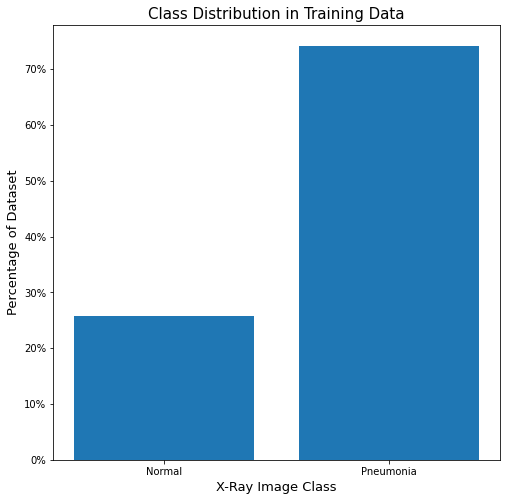

In [113]:
# Visualize class distribution in training data
total_images = len(train_normal_images) + len(train_pneumonia_images)
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(x=['Normal', 'Pneumonia'], height=[len(train_normal_images)/total_images, 
                                                  len(train_pneumonia_images)/total_images])
ax.set_title('Class Distribution in Training Data', size=15)
ax.set_ylabel('Percentage of Dataset', size=13)
ax.set_xlabel('X-Ray Image Class', size=13)
ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])
plt.show()

Clearly not an even distribution! So many more pneumonia images, probably an over-representation.

## Loading images for modeling

We'll use the `ImageDataGenerator` class from Keras, as well as `flow_from_directory` to feed the images into the model.

## First Simple Model

Using simple fully connected Dense layers, no fancy stuff, no convolutions yet.

In [11]:
X_train, X_val, train_labels, val_labels = preprocess_dense_data(train_dir,
                                                                 target_size=(100, 100), 
                                                                 batch_size=50)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [12]:
# Instatiate model
model = models.Sequential()

# Add model layers
model.add(Dense(32, activation='relu', input_shape=(10000,)))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc', 'Recall'])

In [13]:
# Train the model
history = model.fit(X_train, train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_val, val_labels))

Epoch 1/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7343 - acc: 0.3000 - recall: 0.1667WARNING:tensorflow:From /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5/5 [==============================] - 0s 75ms/step - loss: 0.6446 - acc: 0.7200 - recall: 0.8718 - val_loss: 0.4811 - val_acc: 0.8000 - val_recall: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5605 - acc: 0.7800 - recall: 1.0000 - val_loss: 0.5046 - val_acc: 0.8000 - val_recall: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4948 - acc: 0.7800 - recall: 1.0000 - val_loss: 0.4695 - val_acc: 0.8000 - val_recall: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4977 - acc: 0.7800 - recall: 1.0000 -

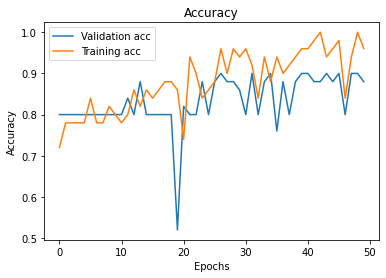

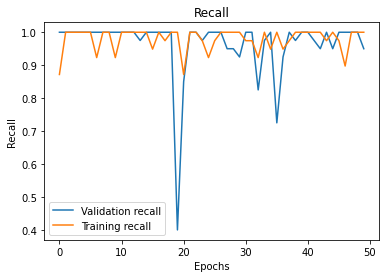

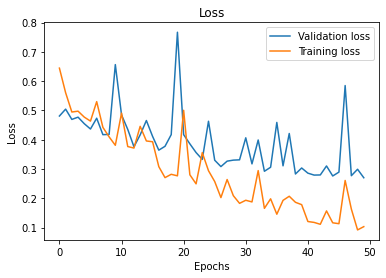

Training eval:
2/2 [==============================] - 0s 2ms/step - loss: 0.0846 - acc: 1.0000 - recall: 1.0000

Validation eval:
2/2 [==============================] - 0s 2ms/step - loss: 0.2703 - acc: 0.8800 - recall: 0.9500


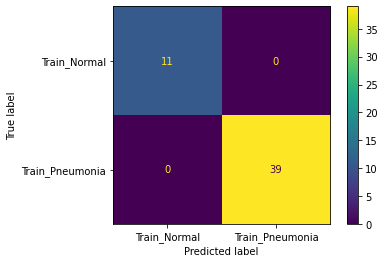

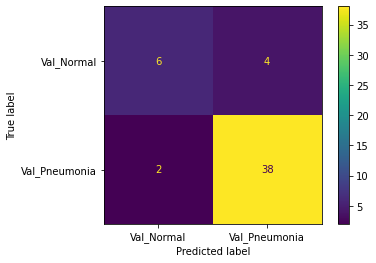

In [14]:
# Visualize the results
visualize_training_results(history, model, X_train, train_labels, X_val, val_labels)

**Analysis:**
Our FSM runs! Huzzah! However, the accuracy and loss are all over the place and overall poor, plus it's super overfit, likely because:
 - we are only training it on 50 images
 - loss of data from resizing the images down to 150x150
 - class imbalance (in favor of Pneumonia lungs)

In [15]:
model.save('first-simple-model.h5')

## Iterating

Our model can definitely improve! The overfitting is likely due to way too few images being used in training, combined with a serious class imbalance in favor of the target class. Also, our model is very basic (only 1 hidden layer), so adding a 2nd hidden layer will likely help.

In [118]:
i1_X_train, i1_X_val, i1_train_labels, i1_val_labels = preprocess_dense_data(train_dir)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


### i1 (iteration one):
 - Bump up size of images to 256x256
 - Increase number of images to 100
 - Add a 2nd hidden layer

In [119]:
# Instatiate model
i1_model = models.Sequential()

# Add model layers - Let's add another hidden layer this time
i1_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i1_model.add(Dense(16, activation='relu'))
i1_model.add(Dense(1, activation='sigmoid'))

# Compile
i1_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [120]:
# Train the model
i1_history = i1_model.fit(i1_X_train, i1_train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(i1_X_val, i1_val_labels))

Epoch 1/50
10/10 [==============================] - 0s 31ms/step - loss: 3.1122 - acc: 0.5900 - recall: 0.6377 - val_loss: 0.8892 - val_acc: 0.2900 - val_recall: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.7519 - acc: 0.6500 - recall: 0.8696 - val_loss: 0.6475 - val_acc: 0.7500 - val_recall: 0.9859
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6178 - acc: 0.7400 - recall: 1.0000 - val_loss: 0.6034 - val_acc: 0.7200 - val_recall: 0.9859
Epoch 4/50
10/10 [==============================] - 0s 11ms/step - loss: 0.8126 - acc: 0.5700 - recall: 0.6667 - val_loss: 0.6033 - val_acc: 0.7100 - val_recall: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6311 - acc: 0.7000 - recall: 1.0000 - val_loss: 0.5672 - val_acc: 0.7100 - val_recall: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.5618 - acc: 0.6900 - recall: 1.0000 - val_loss: 0.5471 - val_acc: 0.7100 - v

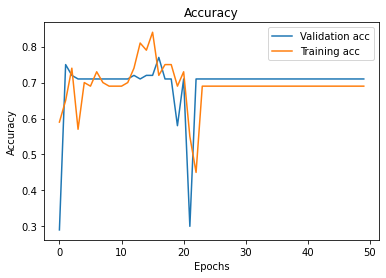

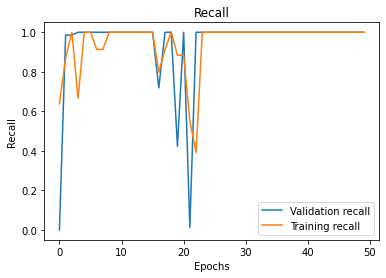

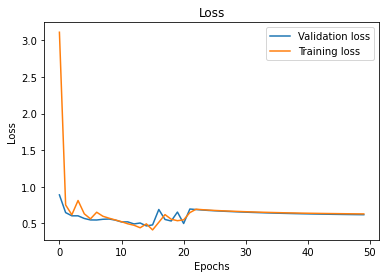

Training eval:
4/4 [==============================] - 0s 3ms/step - loss: 0.6288 - acc: 0.6900 - recall: 1.0000

Validation eval:
4/4 [==============================] - 0s 3ms/step - loss: 0.6186 - acc: 0.7100 - recall: 1.0000


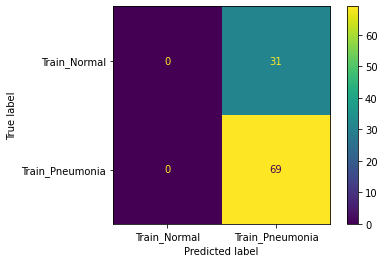

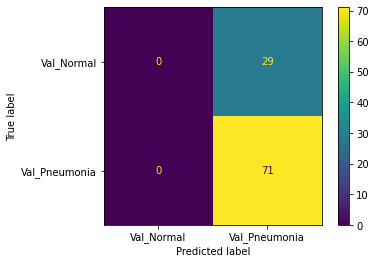

In [121]:
visualize_training_results(i1_history, i1_model, i1_X_train, i1_train_labels, i1_X_val, i1_val_labels)

It's slightly less overfit, but the accuracy/loss curves are still all over the place.

In [84]:
i1_model.save('i1_model.h5')

### i2 (iteration two):
 - Include `class_weight` parameter during model fitting/training
 - Increase number of images to 500
 - Add a 3nd hidden layer

To get the class weights, I've gone back and added the option to return a dictionary `class_weights` from the `preprocess_dense_data` function.

In [9]:
# Preprocess the data
i2_X_train, i2_X_val, i2_train_labels, i2_val_labels = preprocess_dense_data(train_dir, batch_size=500)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [33]:
# Get the class weights
i2_class_weights = get_class_weights(i2_train_labels)

In [8]:
# Instatiate model
i2_model = models.Sequential()

# Add model layers - Same as previous model
i2_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i2_model.add(Dense(16, activation='relu'))
i2_model.add(Dense(1, activation='sigmoid'))

# Compile
i2_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [69]:
# Train the model - This time incorporating class_weights
i2_history = i2_model.fit(i2_X_train, i2_train_labels, 
                          epochs=50,
                          batch_size=10,
                          class_weight=i2_class_weights,
                          validation_data=(i2_X_val, i2_val_labels))

Epoch 1/50
50/50 [==============================] - 1s 12ms/step - loss: 0.7237 - acc: 0.5240 - recall: 0.5317 - val_loss: 0.9707 - val_acc: 0.2460 - val_recall: 0.0000e+00
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.6807 - acc: 0.4320 - recall: 0.3113 - val_loss: 0.6463 - val_acc: 0.8540 - val_recall: 0.9708
Epoch 3/50
50/50 [==============================] - 0s 9ms/step - loss: 0.6478 - acc: 0.6060 - recall: 0.5923 - val_loss: 0.5255 - val_acc: 0.8420 - val_recall: 0.8302
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5554 - acc: 0.6880 - recall: 0.6474 - val_loss: 0.3507 - val_acc: 0.8320 - val_recall: 0.9867
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5511 - acc: 0.6920 - recall: 0.6391 - val_loss: 0.5241 - val_acc: 0.6820 - val_recall: 0.5836
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5635 - acc: 0.6860 - recall: 0.6143 - val_loss: 0.4380 - val_acc: 0.7500 - val_re

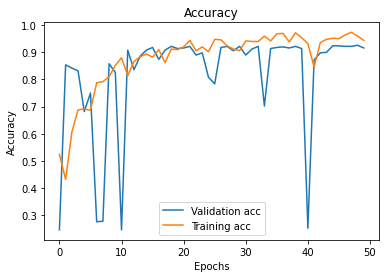

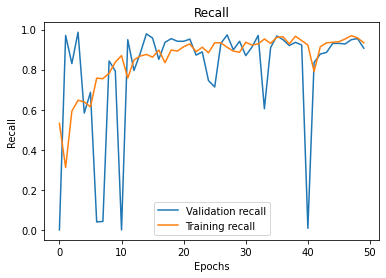

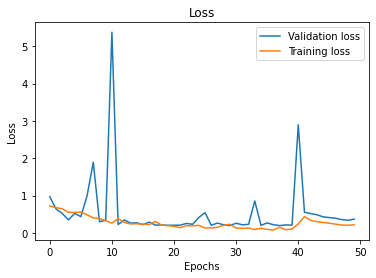

Training eval:
16/16 [==============================] - 0s 6ms/step - loss: 0.2300 - acc: 0.9700 - recall: 0.9614

Validation eval:
16/16 [==============================] - 0s 5ms/step - loss: 0.3723 - acc: 0.9160 - recall: 0.9072


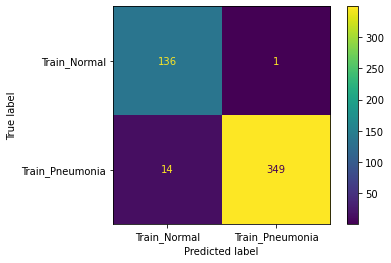

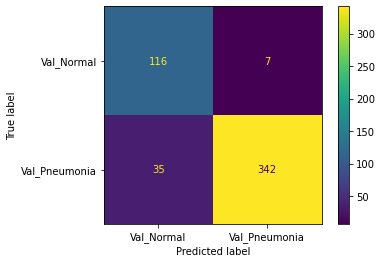

In [90]:
visualize_training_results(i2_history, i2_model, i2_X_train, i2_train_labels, i2_X_val, i2_val_labels)

In [85]:
i2_model.save('i2_model.h5')

Another improvement! Adding the `class_weight` parameter helped close the gap between training and validation data and increased overall accuracy. However, the metrics are still all over the place. Adding more data is likely to help, as could adding more hidden layers.

### i3 (iteration three):
 - Increase number of images to 2000
 - Add more hidden layers
 - Add l2 regularization to Dense layers (to help with overfitting)

In [79]:
i3_X_train, i3_X_val, i3_train_labels, i3_val_labels = preprocess_dense_data(train_dir, batch_size=2000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [80]:
i3_class_weights = get_class_weights(i3_train_labels)

In [81]:
# Instatiate model
i3_model = models.Sequential()

# Add model layers - More layers and with l2 regularization
i3_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i3_model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(1, activation='sigmoid', ))

# Compile
i3_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [82]:
# Train the model
i3_history = i3_model.fit(i3_X_train, i3_train_labels, 
                          epochs=100,
                          batch_size=32,
                          class_weight=i3_class_weights,
                          validation_data=(i3_X_val, i3_val_labels))

Epoch 1/100
63/63 [==============================] - 1s 18ms/step - loss: 1.3261 - acc: 0.7430 - recall: 0.9606 - val_loss: 1.1977 - val_acc: 0.7426 - val_recall: 1.0000
Epoch 2/100
63/63 [==============================] - 1s 14ms/step - loss: 1.2554 - acc: 0.7865 - recall: 0.9077 - val_loss: 1.0688 - val_acc: 0.7493 - val_recall: 1.0000
Epoch 3/100
63/63 [==============================] - 1s 13ms/step - loss: 1.1895 - acc: 0.7970 - recall: 0.8466 - val_loss: 1.3384 - val_acc: 0.2593 - val_recall: 0.0026
Epoch 4/100
63/63 [==============================] - 1s 13ms/step - loss: 1.2583 - acc: 0.6090 - recall: 0.5995 - val_loss: 0.9698 - val_acc: 0.8258 - val_recall: 0.9884
Epoch 5/100
63/63 [==============================] - 1s 13ms/step - loss: 1.0948 - acc: 0.8445 - recall: 0.8737 - val_loss: 0.9118 - val_acc: 0.8804 - val_recall: 0.9781
Epoch 6/100
63/63 [==============================] - 1s 13ms/step - loss: 1.0672 - acc: 0.7930 - recall: 0.7766 - val_loss: 1.1917 - val_acc: 0.5732 -

Epoch 49/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3740 - acc: 0.9440 - recall: 0.9369 - val_loss: 0.3620 - val_acc: 0.9435 - val_recall: 0.9497
Epoch 50/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3537 - acc: 0.9520 - recall: 0.9450 - val_loss: 0.3559 - val_acc: 0.9455 - val_recall: 0.9523
Epoch 51/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3521 - acc: 0.9480 - recall: 0.9403 - val_loss: 0.3503 - val_acc: 0.9474 - val_recall: 0.9549
Epoch 52/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3496 - acc: 0.9470 - recall: 0.9423 - val_loss: 0.3724 - val_acc: 0.9321 - val_recall: 0.9188
Epoch 53/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3464 - acc: 0.9515 - recall: 0.9477 - val_loss: 0.3861 - val_acc: 0.9187 - val_recall: 0.9008
Epoch 54/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3347 - acc: 0.9520 - recall: 0.9457 - val_loss: 0.3369 - val_acc: 0.

Epoch 97/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1666 - acc: 0.9770 - recall: 0.9722 - val_loss: 0.2676 - val_acc: 0.9254 - val_recall: 0.9085
Epoch 98/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1904 - acc: 0.9620 - recall: 0.9572 - val_loss: 0.2694 - val_acc: 0.9292 - val_recall: 0.9781
Epoch 99/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1749 - acc: 0.9700 - recall: 0.9654 - val_loss: 0.3812 - val_acc: 0.8813 - val_recall: 0.8415
Epoch 100/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1836 - acc: 0.9615 - recall: 0.9552 - val_loss: 0.2434 - val_acc: 0.9301 - val_recall: 0.9175


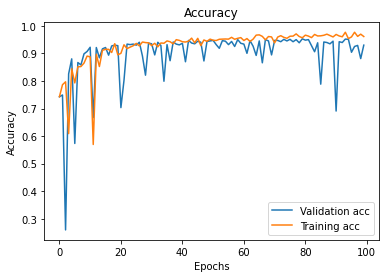

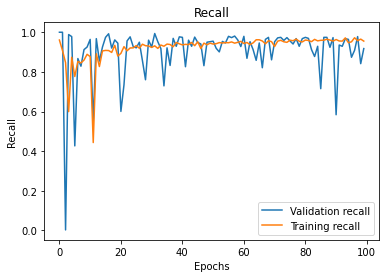

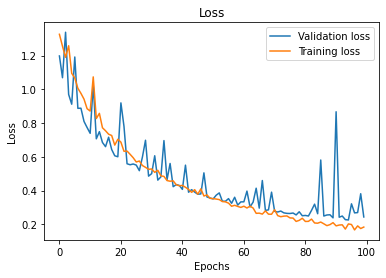

Training eval:
63/63 [==============================] - 0s 5ms/step - loss: 0.1737 - acc: 0.9700 - recall: 0.9593

Validation eval:
33/33 [==============================] - 0s 4ms/step - loss: 0.2434 - acc: 0.9301 - recall: 0.9175


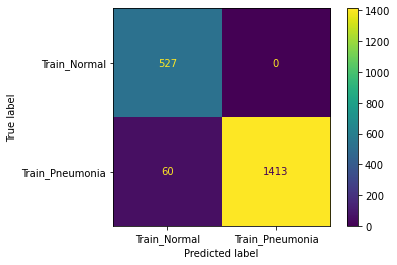

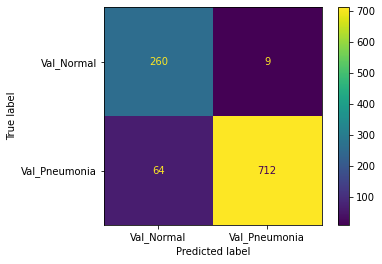

In [91]:
visualize_training_results(i3_history, i3_model, i3_X_train, i3_train_labels, i3_X_val, i3_val_labels)

In [86]:
i3_model.save('i3_model.h5')

### i4 (iteration four):
 - Try a different optimizer
 - Add Dropout layers

In [59]:
i4_X_train, i4_X_val, i4_train_labels, i4_val_labels = preprocess_dense_data(train_dir, batch_size=4187)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [58]:
len(i4_X_train)

2000

In [60]:
i4_class_weights = get_class_weights(i4_train_labels)

In [61]:
# Instatiate model
i4_model = models.Sequential()

# Add model layers - More layers and with l2 regularization
i4_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i4_model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.01)))
i4_model.add(Dropout(0.1))
i4_model.add(Dense(18, activation='relu', kernel_regularizer=l2(l2=0.01)))
i4_model.add(Dropout(0.1))
i4_model.add(Dense(16, activation='relu', kernel_regularizer=l2(l2=0.01)))
i4_model.add(Dropout(0.1))
i4_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i4_model.add(Dropout(0.1))
i4_model.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=0.01)))
i4_model.add(Dropout(0.1))
i4_model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=0.01)))
i4_model.add(Dense(1, activation='sigmoid', ))

# Compile
i4_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [62]:
# Train the model
i4_history = i4_model.fit(i4_X_train, i4_train_labels, 
                          epochs=100,
                          batch_size=32,
                          class_weight=i4_class_weights,
                          validation_data=(i4_X_val, i4_val_labels))

Epoch 1/100
131/131 [==============================] - 4s 32ms/step - loss: 1.3916 - acc: 0.4569 - recall: 0.3911 - val_loss: 1.2173 - val_acc: 0.3904 - val_recall: 0.1791
Epoch 2/100
131/131 [==============================] - 3s 20ms/step - loss: 1.0037 - acc: 0.6702 - recall: 0.5951 - val_loss: 0.9222 - val_acc: 0.9081 - val_recall: 0.9562
Epoch 3/100
131/131 [==============================] - 3s 20ms/step - loss: 0.7513 - acc: 0.8629 - recall: 0.8581 - val_loss: 0.9074 - val_acc: 0.7837 - val_recall: 0.7088
Epoch 4/100
131/131 [==============================] - 3s 19ms/step - loss: 0.6118 - acc: 0.9150 - recall: 0.9144 - val_loss: 0.7058 - val_acc: 0.9005 - val_recall: 0.8789
Epoch 5/100
131/131 [==============================] - 3s 21ms/step - loss: 0.5268 - acc: 0.9343 - recall: 0.9401 - val_loss: 0.5857 - val_acc: 0.9359 - val_recall: 0.9394
Epoch 6/100
131/131 [==============================] - 3s 20ms/step - loss: 0.4787 - acc: 0.9312 - recall: 0.9417 - val_loss: 0.5833 - val_a

131/131 [==============================] - 3s 20ms/step - loss: 0.0764 - acc: 0.9864 - recall: 0.9881 - val_loss: 0.4455 - val_acc: 0.9301 - val_recall: 0.9201
Epoch 96/100
131/131 [==============================] - 3s 21ms/step - loss: 0.0767 - acc: 0.9881 - recall: 0.9903 - val_loss: 0.2543 - val_acc: 0.9474 - val_recall: 0.9613
Epoch 97/100
131/131 [==============================] - 3s 21ms/step - loss: 0.0708 - acc: 0.9878 - recall: 0.9894 - val_loss: 0.2543 - val_acc: 0.9426 - val_recall: 0.9510
Epoch 98/100
131/131 [==============================] - 3s 20ms/step - loss: 0.0646 - acc: 0.9904 - recall: 0.9926 - val_loss: 0.3456 - val_acc: 0.9225 - val_recall: 0.9085
Epoch 99/100
131/131 [==============================] - 3s 22ms/step - loss: 0.0745 - acc: 0.9854 - recall: 0.9874 - val_loss: 0.2535 - val_acc: 0.9483 - val_recall: 0.9549
Epoch 100/100
131/131 [==============================] - 3s 20ms/step - loss: 0.0643 - acc: 0.9919 - recall: 0.9929 - val_loss: 0.3212 - val_acc: 0.

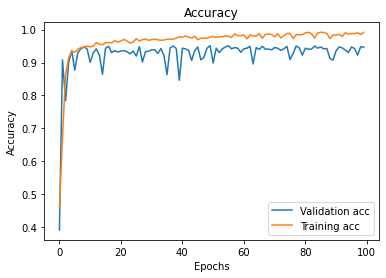

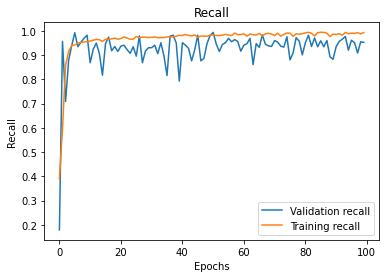

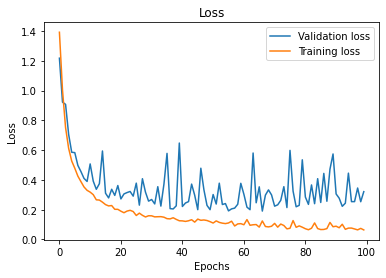

Training eval:
131/131 [==============================] - 1s 6ms/step - loss: 0.0467 - acc: 0.9976 - recall: 0.9987

Validation eval:
33/33 [==============================] - 0s 5ms/step - loss: 0.3212 - acc: 0.9464 - recall: 0.9523


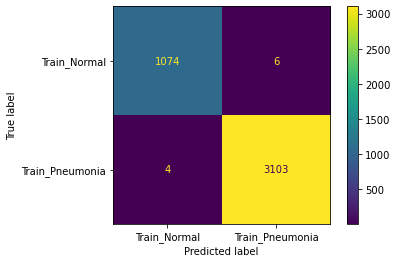

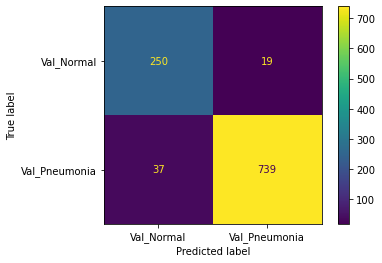

In [63]:
visualize_training_results(i4_history, i4_model, i4_X_train, i4_train_labels, i4_X_val, i4_val_labels)

Best yet! Still showing signs of overfitting, but improving on all our metrics.

In [64]:
i4_model.save('i4_model_with_dropout.h5')

Can we see any patterns for ourselves in the misclassified images?

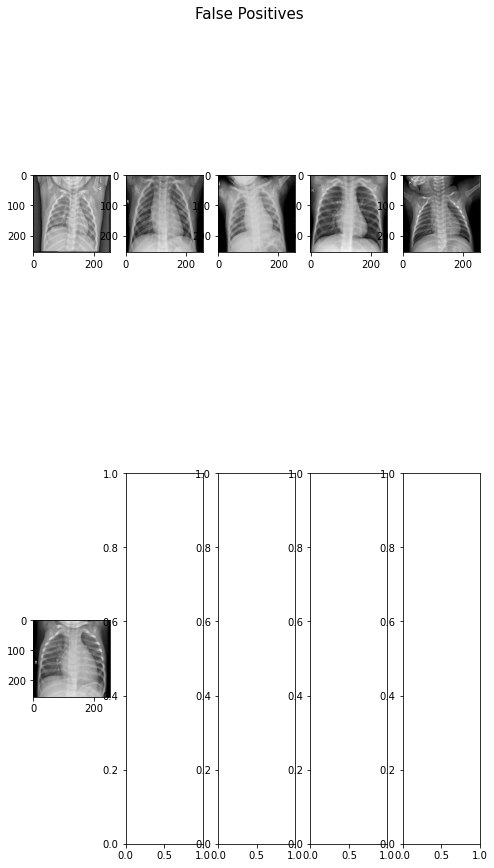

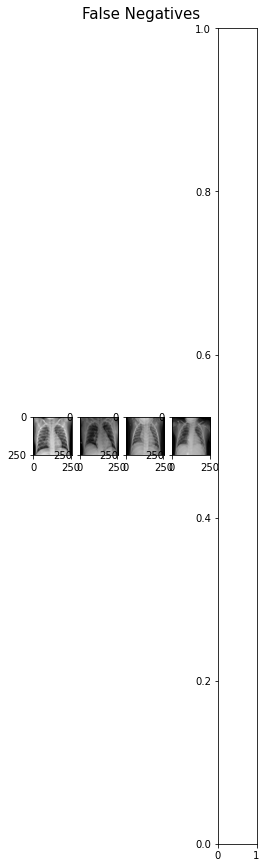

In [65]:
show_misclassfied_images(i4_model, i4_X_train, i4_train_labels, size=(12, 15))

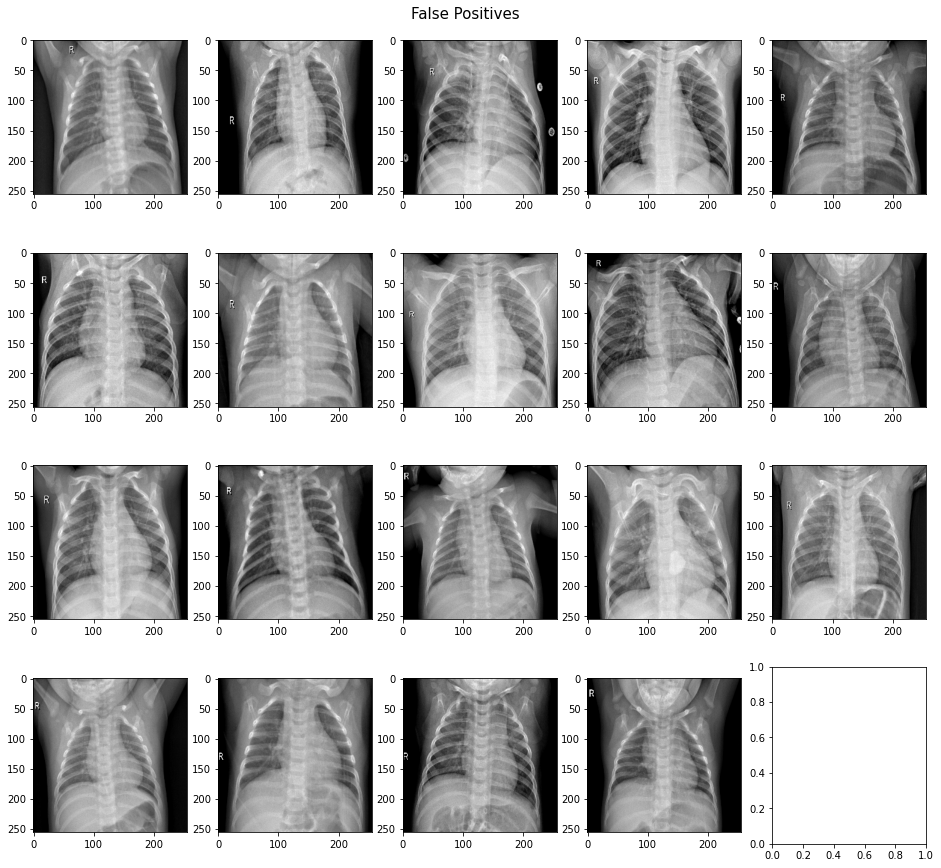

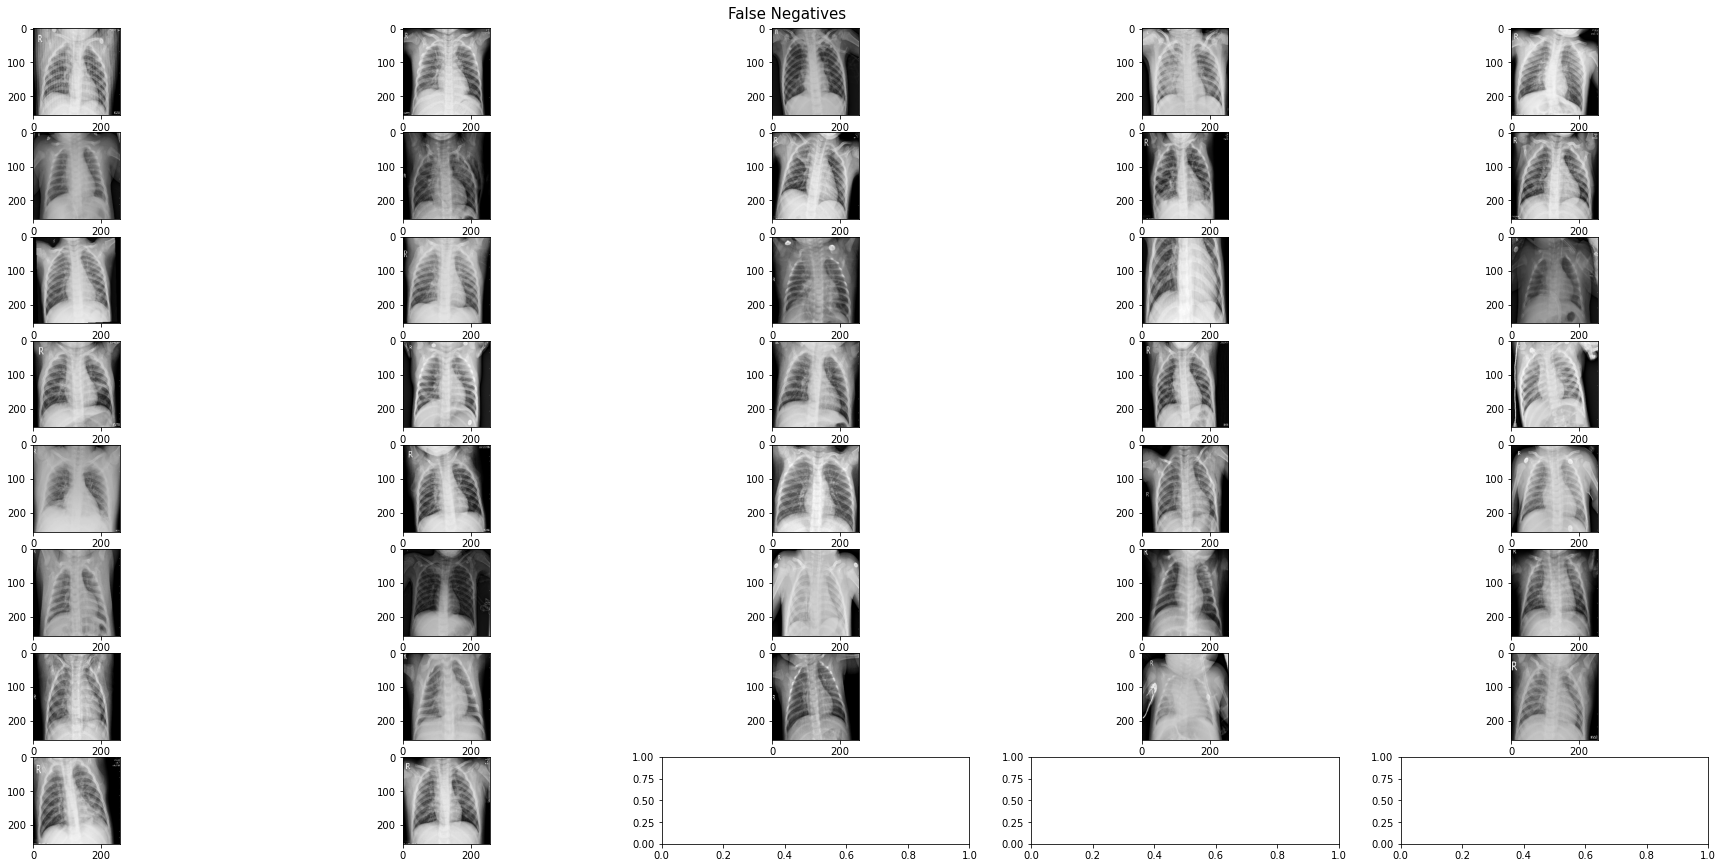

In [66]:
show_misclassfied_images(i4_model, i4_X_val, i4_val_labels)

### i5 (iteration five):
 - Leaky ReLU activation (Note: tried it, did not help)
 - Try with/without class weights
 - Try adjusting the learning rate, with SGD vs Adam optimizers

In [26]:
from keras.optimizers import Adam, SGD

In [23]:
i5_X_train, i5_X_val, i5_train_labels, i5_val_labels = preprocess_dense_data(train_dir, batch_size=4000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [27]:
i5_class_weights = get_class_weights(i5_train_labels)

In [31]:
# Instatiate model
i5_model = models.Sequential()

# Add model layers - More layers and with l2 regularization
i5_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i5_model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(18, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(16, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(1, activation='sigmoid', ))


In [32]:
# Compile
adam = Adam(lr=0.001)
i5_model.compile(optimizer=adam,
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

# Train the model
i5_history = i5_model.fit(i5_X_train, i5_train_labels, 
                          epochs=100,
                          batch_size=32,
                          class_weight=i5_class_weights,
                          validation_data=(i5_X_val, i5_val_labels))

Epoch 1/100
125/125 [==============================] - 2s 18ms/step - loss: 1.0345 - acc: 0.8307 - recall: 0.8253 - val_loss: 0.6784 - val_acc: 0.9282 - val_recall: 0.9613
Epoch 2/100
125/125 [==============================] - 2s 16ms/step - loss: 0.6197 - acc: 0.9107 - recall: 0.9111 - val_loss: 0.5150 - val_acc: 0.9215 - val_recall: 0.9794
Epoch 3/100
125/125 [==============================] - 2s 16ms/step - loss: 0.4473 - acc: 0.9305 - recall: 0.9283 - val_loss: 0.7520 - val_acc: 0.8048 - val_recall: 0.7384
Epoch 4/100
125/125 [==============================] - 2s 16ms/step - loss: 0.3898 - acc: 0.9350 - recall: 0.9343 - val_loss: 0.4004 - val_acc: 0.9167 - val_recall: 0.9871
Epoch 5/100
125/125 [==============================] - 2s 16ms/step - loss: 0.3693 - acc: 0.9290 - recall: 0.9293 - val_loss: 0.3589 - val_acc: 0.9273 - val_recall: 0.9858
Epoch 6/100
125/125 [==============================] - 2s 16ms/step - loss: 0.3571 - acc: 0.9280 - recall: 0.9266 - val_loss: 0.3353 - val_a

125/125 [==============================] - 2s 16ms/step - loss: 0.0700 - acc: 0.9890 - recall: 0.9882 - val_loss: 0.2038 - val_acc: 0.9483 - val_recall: 0.9652
Epoch 96/100
125/125 [==============================] - 2s 17ms/step - loss: 0.0925 - acc: 0.9778 - recall: 0.9754 - val_loss: 0.2310 - val_acc: 0.9426 - val_recall: 0.9845
Epoch 97/100
125/125 [==============================] - 2s 18ms/step - loss: 0.0598 - acc: 0.9940 - recall: 0.9933 - val_loss: 0.2979 - val_acc: 0.9292 - val_recall: 0.9137
Epoch 98/100
125/125 [==============================] - 2s 17ms/step - loss: 0.0681 - acc: 0.9895 - recall: 0.9882 - val_loss: 0.2407 - val_acc: 0.9445 - val_recall: 0.9381
Epoch 99/100
125/125 [==============================] - 2s 18ms/step - loss: 0.0567 - acc: 0.9940 - recall: 0.9929 - val_loss: 0.2095 - val_acc: 0.9522 - val_recall: 0.9794
Epoch 100/100
125/125 [==============================] - 2s 17ms/step - loss: 0.0967 - acc: 0.9812 - recall: 0.9798 - val_loss: 0.2019 - val_acc: 0.

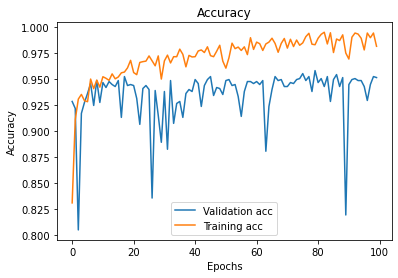

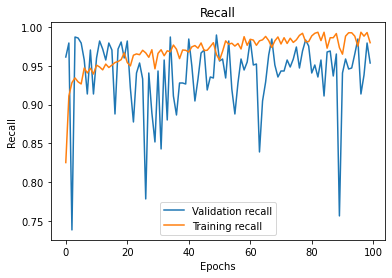

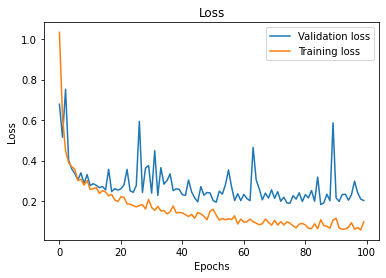

Training eval:
125/125 [==============================] - 1s 5ms/step - loss: 0.0551 - acc: 0.9960 - recall: 0.9949

Validation eval:
33/33 [==============================] - 0s 5ms/step - loss: 0.2019 - acc: 0.9512 - recall: 0.9536


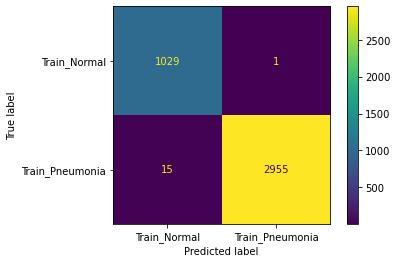

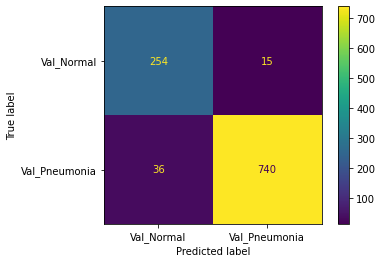

In [33]:
visualize_training_results(i5_history, i5_model, i5_X_train, i5_train_labels, i5_X_val, i5_val_labels)

## Using [Lime](https://github.com/marcotcr/lime) to visualize what layers are doing

In [51]:
import lime
from lime import lime_image

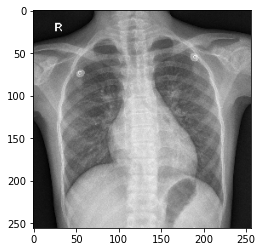

In [48]:
plt.imshow(i5_X_train[0].reshape(256, -1), cmap='gray')
preds = i5_model.predict(i5_X_train)

In [57]:
preds

array([[0.01657951],
       [0.99532413],
       [0.00189462],
       ...,
       [0.00819865],
       [0.00296041],
       [0.00200385]], dtype=float32)

In [58]:
explainer = lime_image.LimeImageExplainer()

In [59]:
image = i5_X_train[0].reshape(256, -1)
explanation = explainer.explain_instance(image.astype('double'), 
                                         i5_model.predict, 
                                         labels=(1,), 
                                         top_labels=None, hide_color=0, num_samples=1000)

ValueError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 65536 but received input with shape [None, 256, 256, 3]


It seems like Lime isn't going to work (or at least, not easily) with the dense, fully connected NNs in this notebook. It wants an image in the `explain_instance()` method, but that (unflattened) image can't then be handled by the `model.predict` function also passed in (it needs a flattened image). I'll leave this for now and see if this can be implemented instead with the CNN models in the other notebook.